# Sistema de clasificación de imágenes
El conjunto de datos se compone de fotos de perros y gatos proporcionadas como un subconjunto de fotos de uno mucho más grande de 3 millones de fotos anotadas manualmente. Estos datos se obtuvieron a través de una colaboración entre Petfinder.com y Microsoft.

El conjunto de datos se usó originalmente como un CAPTCHA, es decir, una tarea que se cree que un humano encuentra trivial, pero que una máquina no puede resolver, que se usa en sitios web para distinguir entre usuarios humanos y bots. La tarea se denominó "Asirra". Cuando se presentó "Asirra", se mencionó "que los estudios de usuarios indican que los humanos pueden resolverlo el 99,6% de las veces en menos de 30 segundos". A menos que se produzca un gran avance en la visión artificial, esperamos que los ordenadores no tengan más de 1/54.000 posibilidades de resolverlo.

En el momento en que se publicó la competencia, el resultado de última generación se logró con un SVM y se describió en un artículo de 2007 con el título "Ataques de Machine Learning contra el CAPTCHA de Asirra" (PDF) que logró una precisión de clasificación del 80%. Fue este documento el que demostró que la tarea ya no era una tarea adecuada para un CAPTCHA poco después de que se propusiera la tarea

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1
Path to dataset files: /home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1


In [2]:
import os

dataset_path = "/home/vscode/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1"

# Listar archivos en la carpeta
files = os.listdir(dataset_path)
print(files)

['dogs_vs_cats', 'train.csv', 'train', 'test']


In [3]:
import os
import pandas as pd

# Ruta a la carpeta "train" que contiene "cats" y "dogs"
image_folder = os.path.join(dataset_path, "train")

# Recorrer subcarpetas y recolectar imágenes
image_paths = []
labels = []

for label in os.listdir(image_folder):
    class_folder = os.path.join(image_folder, label)
    if os.path.isdir(class_folder):
        for file in os.listdir(class_folder):
            if file.lower().endswith(".jpg"):
                image_paths.append(os.path.join(class_folder, file))
                labels.append(label)  # 'cats' o 'dogs'

# Crear el DataFrame
df = pd.DataFrame({
    "filepath": image_paths,
    "filename": [os.path.basename(path) for path in image_paths],
    "label": labels
})

# Verificar
print(df.shape)
df.head()


(20000, 3)


,filepath,filename,label
0,/home/vscode/.cache/kagglehub/datasets/salader...,cat.2553.jpg,cats
1,/home/vscode/.cache/kagglehub/datasets/salader...,cat.9923.jpg,cats
2,/home/vscode/.cache/kagglehub/datasets/salader...,cat.3452.jpg,cats
3,/home/vscode/.cache/kagglehub/datasets/salader...,cat.1506.jpg,cats
4,/home/vscode/.cache/kagglehub/datasets/salader...,cat.4072.jpg,cats


In [4]:
# Guardar el DataFrame como CSV
import os
ruta="/workspaces/Clasficador-Imagenes/data"
train_csv_path = os.path.join(ruta, "train.csv")
df.to_csv(train_csv_path, index=False)

print(f"Archivo CSV guardado en: {train_csv_path}")


Archivo CSV guardado en: /workspaces/Clasficador-Imagenes/data/train.csv


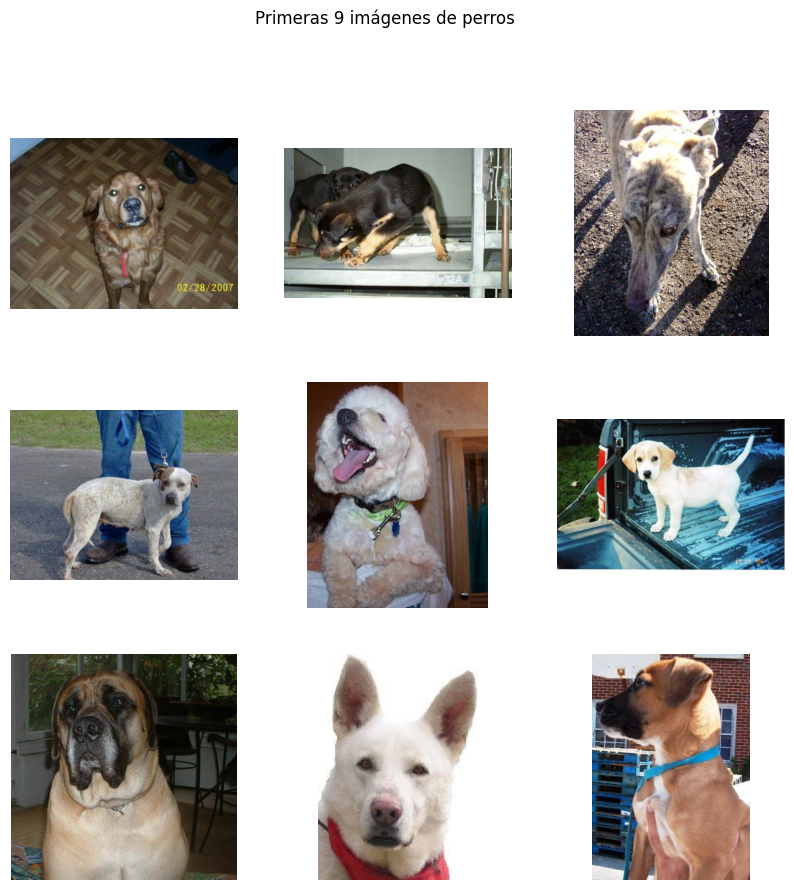

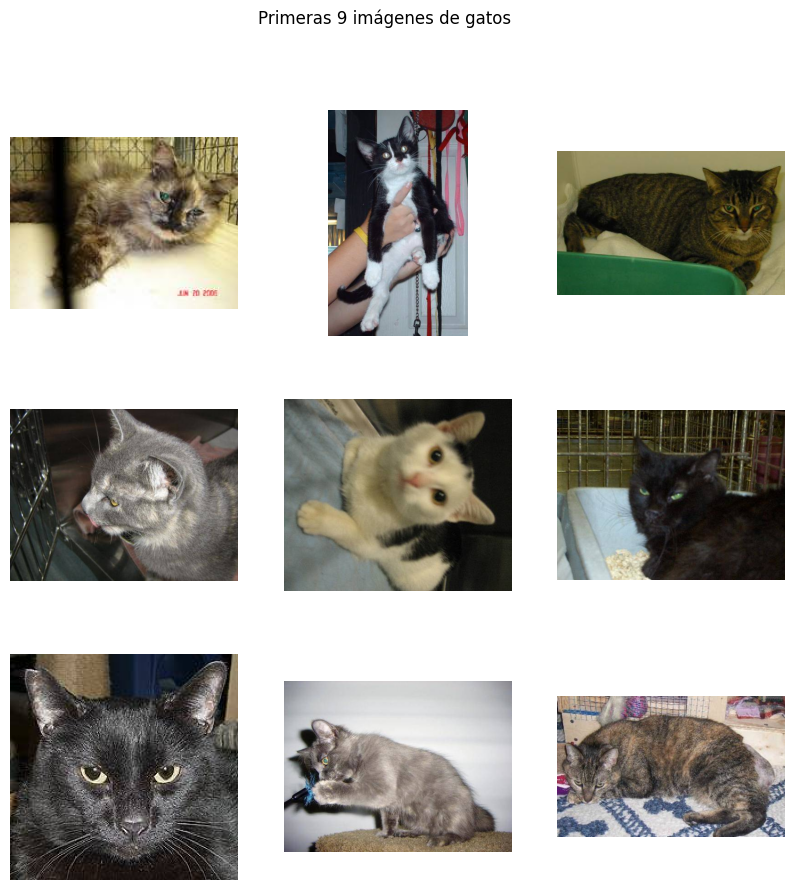

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Obtener rutas de perros y gatos
dog_images = df[df["label"] == "dogs"]["filepath"].tolist()[:9]
cat_images = df[df["label"] == "cats"]["filepath"].tolist()[:9]

# Función para mostrar 9 imágenes
def show_images(image_paths, title):
    plt.figure(figsize=(10, 10))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Mostrar
show_images(dog_images, "Primeras 9 imágenes de perros")
show_images(cat_images, "Primeras 9 imágenes de gatos")


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parámetros
image_size = (200, 200)
batch_size = 32

# Crear generador de datos con validación incluida
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Usamos el 20% para validación
)

# Generador para entrenamiento
train_generator= datagen.flow_from_directory(
    directory=image_folder,         # carpeta que contiene "cats" y "dogs"
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True
)

# Generador para validación
val_generator = datagen.flow_from_directory(
    directory=image_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=False
)


2025-04-16 00:15:39.046344: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 00:15:39.086933: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 00:15:39.097063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744762539.114650   17278 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744762539.119057   17278 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744762539.149776   17278 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [7]:
# Move the Data Through the Neural Network
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

model = Sequential()
model.add(Conv2D(input_shape = (200,200,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 1, activation = "sigmoid"))

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-16 00:15:46.242651: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-04-16 00:15:46.563239: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-04-16 00:15:46.915404: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-04-16 00:15:46.944928: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.


In [9]:
from keras.optimizers import Adam

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])


In [ ]:
#Train the Model
model.fit(train_generator, epochs = 1)

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-16 00:16:44.437314: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-04-16 00:16:46.452261: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.


 38/500 ━━━━━━━━━━━━━━━━━━━━ 4:07:57 32s/step - accuracy: 0.4989 - loss: 0.7062

In [36]:
loss, accuracy = model.evaluate(val_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_14" is incompatible with the layer: expected axis -1 of input shape to have value 25088, but received input with shape (None, 18432)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 200, 200, 3), dtype=float32)
  • training=False
  • mask=None

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_14" is incompatible with the layer: expected axis -1 of input shape to have value 25088, but received input with shape (None, 18432)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 200, 200, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
#Guardar el modelo
from pickle import dump

dump(model, open("../models/DecisionTreeRegressor_default_42.sav", "wb"))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("../models/vgg16_1.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto")
early = EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 1, mode = "auto")
hist = model.fit(train_data, steps_per_epoch = 100, validation_data = test_data, validation_steps = 10, epochs = 3, callbacks = [checkpoint, early])

In [ ]:
# Check the Accuracy of the Data

# Plot the Results
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

# Configure the Plot Layout
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])

# Plot
plt.show()

In [ ]:
from keras.preprocessing import image
from keras.models import load_model

img = image.load_img("../data/raw/test/9.jpg", target_size = (200, 200))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
saved_model = load_model("../models/vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print("dog")

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Callback para guardar el mejor modelo basado en la métrica de validación
checkpoint = ModelCheckpoint(
    filepath='mejor_modelo.h5',      # archivo donde se guarda el modelo
    monitor='val_accuracy',          # métrica que se va a observar
    save_best_only=True,             # guarda solo si mejora
    mode='max',                      # porque estamos maximizando la accuracy
    verbose=1
)

# Callback para detener el entrenamiento si no mejora
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,                      # espera 5 epochs sin mejora
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Entrenamiento del modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,   # asegúrate de tener val_generator definido
    callbacks=[checkpoint, early_stop]
)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("../models/vgg16_1.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto")
early = EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 1, mode = "auto")
hist = model.fit(train_data, steps_per_epoch = 100, validation_data = test_data, validation_steps = 10, epochs = 3, callbacks = [checkpoint, early])